# Identifying Modularization Options based on Code Changes

## Part 1: Analysing existing Modularization

### Stating Question
_"How suitable is the domain modularization for the actual development activities?"_

### Idea
Heuristic: "Are changes in one module cohesive?"
* Changes => commits from version control system
* Module => Part of file path


### Data import and preparation

#### Import Git log data

In [1]:
import pandas as pd
git_log = pd.read_csv("../datasets/git_log_numstat_dropover.csv")[['sha', 'file']]
git_log.head()

sha                                               file
0  8c686954            backend/pom-2016-07-16_04-40-56-752.xml
1  97c6ef96  backend/src/test/java/at/dropover/scheduling/i...
2  432113a2  backend/src/test/java/at/dropover/scheduling/i...
3  3f7cf92c  backend/src/main/webapp/app/widgets/gallery/js...
4  bf2b00ba  backend/src/main/webapp/app/widgets/gallery/js...

#### Just keep Java production code

In [2]:
prod_code = git_log.copy()
prod_code = prod_code[prod_code.file.str.contains("src/main/java")]
prod_code = prod_code[~prod_code.file.str.endswith("package-info.java")]
prod_code.head()

sha                                               file
9   ec85fe73  backend/src/main/java/at/dropover/files/intera...
10  0732e9cb  backend/src/main/java/at/dropover/files/intera...
11  a526cce1  backend/src/main/java/at/dropover/files/intera...
12  ad06aa87  backend/src/main/java/at/dropover/files/intera...
13  b5dd5695  backend/src/main/java/at/dropover/files/intera...

### Analysis

#### Set marker for Commit

In [3]:
prod_code['commit'] = 1
prod_code.head()

sha                                               file  commit
9   ec85fe73  backend/src/main/java/at/dropover/files/intera...       1
10  0732e9cb  backend/src/main/java/at/dropover/files/intera...       1
11  a526cce1  backend/src/main/java/at/dropover/files/intera...       1
12  ad06aa87  backend/src/main/java/at/dropover/files/intera...       1
13  b5dd5695  backend/src/main/java/at/dropover/files/intera...       1

#### Rotate the data table ("pivoting")

In [4]:
commit_matrix = prod_code.reset_index().pivot_table(
    index='file',
    columns='sha',
    values='commit',
    fill_value=0)
commit_matrix.iloc[0:5,50:55]

sha                                                 3597d8a2  3b70ea7e  \
file                                                                     
backend/src/main/java/at/dropover/comment/bound...         0         0   
backend/src/main/java/at/dropover/comment/bound...         0         0   
backend/src/main/java/at/dropover/comment/bound...         0         0   
backend/src/main/java/at/dropover/comment/bound...         0         0   
backend/src/main/java/at/dropover/comment/bound...         0         0   

sha                                                 3d3be4ca  3e4ae692  \
file                                                                     
backend/src/main/java/at/dropover/comment/bound...         0         0   
backend/src/main/java/at/dropover/comment/bound...         0         1   
backend/src/main/java/at/dropover/comment/bound...         0         1   
backend/src/main/java/at/dropover/comment/bound...         0         0   
backend/src/main/java/at/dropover/comment/bound...         0         0   

sha                                                 429b3b32  
file                                                          
backend/src/main/java/at/dropover/comment/bound...         0  
backend/src/main/java/at/dropover/comment/bound...         0  
backend/src/main/java/at/dropover/comment/bound...         0  
backend/src/main/java/at/dropover/comment/bound...         0  
backend/src/main/java/at/dropover/comment/bound...         0

#### Calculate distances between vectors

In [5]:
from sklearn.metrics.pairwise import cosine_distances

dissimilarity_matrix = cosine_distances(commit_matrix)
dissimilarity_matrix[:5,:5]

array([[0.        , 0.29289322, 0.5       , 0.18350342, 0.29289322],
       [0.29289322, 0.        , 0.29289322, 0.1339746 , 0.5       ],
       [0.5       , 0.29289322, 0.        , 0.59175171, 0.29289322],
       [0.18350342, 0.1339746 , 0.59175171, 0.        , 0.42264973],
       [0.29289322, 0.5       , 0.29289322, 0.42264973, 0.        ]])

#### (Pretty print results)

In [6]:
import pandas as pd
dissimilarity_df = pd.DataFrame(
    dissimilarity_matrix,
    index=commit_matrix.index,
    columns=commit_matrix.index)
dissimilarity_df.iloc[:5,:2]


file                                                backend/src/main/java/at/dropover/comment/boundary/AddCommentRequestModel.java  \
file                                                                                                                                 
backend/src/main/java/at/dropover/comment/bound...                                           0.000000                                
backend/src/main/java/at/dropover/comment/bound...                                           0.292893                                
backend/src/main/java/at/dropover/comment/bound...                                           0.500000                                
backend/src/main/java/at/dropover/comment/bound...                                           0.183503                                
backend/src/main/java/at/dropover/comment/bound...                                           0.292893                                

file                                                backend/src/main/java/at/dropover/comment/boundary/ChangeCommentRequestModel.java  
file                                                                                                                                   
backend/src/main/java/at/dropover/comment/bound...                                           0.292893                                  
backend/src/main/java/at/dropover/comment/bound...                                           0.000000                                  
backend/src/main/java/at/dropover/comment/bound...                                           0.292893                                  
backend/src/main/java/at/dropover/comment/bound...                                           0.133975                                  
backend/src/main/java/at/dropover/comment/bound...                                           0.500000

### Interpretation

#### Reduce dimensions

In [7]:
from sklearn.manifold import MDS

# uses a fixed seed for random_state for reproducibility
model = MDS(dissimilarity='precomputed', random_state=0)
dissimilarity_2d = model.fit_transform(dissimilarity_df)
dissimilarity_2d[:5]

array([[-0.5259277 ,  0.45070158],
       [-0.56826041,  0.21528001],
       [-0.52746829,  0.34756761],
       [-0.55856713,  0.26202797],
       [-0.4036568 ,  0.49803657]])

#### (Pretty print results)

In [8]:
dissimilarity_2d_df = pd.DataFrame(
    dissimilarity_2d,
    index=commit_matrix.index,
    columns=["x", "y"])
dissimilarity_2d_df.head()

x         y
file                                                                  
backend/src/main/java/at/dropover/comment/bound... -0.525928  0.450702
backend/src/main/java/at/dropover/comment/bound... -0.568260  0.215280
backend/src/main/java/at/dropover/comment/bound... -0.527468  0.347568
backend/src/main/java/at/dropover/comment/bound... -0.558567  0.262028
backend/src/main/java/at/dropover/comment/bound... -0.403657  0.498037

#### Extract module information

In [9]:
dissimilarity_2d_df['module'] = dissimilarity_2d_df.index.str.split("/").str[6].values
dissimilarity_2d_df.head()

x         y  \
file                                                                     
backend/src/main/java/at/dropover/comment/bound... -0.525928  0.450702   
backend/src/main/java/at/dropover/comment/bound... -0.568260  0.215280   
backend/src/main/java/at/dropover/comment/bound... -0.527468  0.347568   
backend/src/main/java/at/dropover/comment/bound... -0.558567  0.262028   
backend/src/main/java/at/dropover/comment/bound... -0.403657  0.498037   

                                                     module  
file                                                         
backend/src/main/java/at/dropover/comment/bound...  comment  
backend/src/main/java/at/dropover/comment/bound...  comment  
backend/src/main/java/at/dropover/comment/bound...  comment  
backend/src/main/java/at/dropover/comment/bound...  comment  
backend/src/main/java/at/dropover/comment/bound...  comment

### Visualization

#### Create an interactive graphic

In [10]:
from ausi import pygal
xy = pygal.create_xy_chart(dissimilarity_2d_df,"module")
xy.render_in_browser()

file://C:/Users/MARKUS~1/AppData/Local/Temp/tmpicpvwfh4.html


## Part 2: Alternative modularization

### Stating Question

_Does an alternative modularization based on the change behavior exist?_

### Idea

Cluster source code files according to their distances

In [11]:
commit_matrix.head()

sha                                                 006b089a  00b3c3c6  \
file                                                                     
backend/src/main/java/at/dropover/comment/bound...         0         0   
backend/src/main/java/at/dropover/comment/bound...         0         0   
backend/src/main/java/at/dropover/comment/bound...         0         0   
backend/src/main/java/at/dropover/comment/bound...         0         0   
backend/src/main/java/at/dropover/comment/bound...         0         0   

sha                                                 0405d46b  04692c51  \
file                                                                     
backend/src/main/java/at/dropover/comment/bound...         0         0   
backend/src/main/java/at/dropover/comment/bound...         0         0   
backend/src/main/java/at/dropover/comment/bound...         0         0   
backend/src/main/java/at/dropover/comment/bound...         0         0   
backend/src/main/java/at/dropover/comment/bound...         0         0   

sha                                                 04bed47e  0611265f  \
file                                                                     
backend/src/main/java/at/dropover/comment/bound...         0         0   
backend/src/main/java/at/dropover/comment/bound...         0         0   
backend/src/main/java/at/dropover/comment/bound...         0         0   
backend/src/main/java/at/dropover/comment/bound...         0         0   
backend/src/main/java/at/dropover/comment/bound...         0         0   

sha                                                 0732e9cb  093122ab  \
file                                                                     
backend/src/main/java/at/dropover/comment/bound...         0         0   
backend/src/main/java/at/dropover/comment/bound...         0         0   
backend/src/main/java/at/dropover/comment/bound...         0         0   
backend/src/main/java/at/dropover/comment/bound...         0         0   
backend/src/main/java/at/dropover/comment/bound...         0         0   

sha                                                 0937d598  095c56a8  \
file                                                                     
backend/src/main/java/at/dropover/comment/bound...         0         0   
backend/src/main/java/at/dropover/comment/bound...         0         0   
backend/src/main/java/at/dropover/comment/bound...         0         0   
backend/src/main/java/at/dropover/comment/bound...         0         0   
backend/src/main/java/at/dropover/comment/bound...         0         0   

sha                                                   ...     f541acab  \
file                                                  ...                
backend/src/main/java/at/dropover/comment/bound...    ...            0   
backend/src/main/java/at/dropover/comment/bound...    ...            0   
backend/src/main/java/at/dropover/comment/bound...    ...            0   
backend/src/main/java/at/dropover/comment/bound...    ...            0   
backend/src/main/java/at/dropover/comment/bound...    ...            0   

sha                                                 f5d9218d  f60ce811  \
file                                                                     
backend/src/main/java/at/dropover/comment/bound...         0         0   
backend/src/main/java/at/dropover/comment/bound...         0         0   
backend/src/main/java/at/dropover/comment/bound...         0         0   
backend/src/main/java/at/dropover/comment/bound...         0         0   
backend/src/main/java/at/dropover/comment/bound...         0         0   

sha                                                 f7431ebf  f85aa9c9  \
file                                                                     
backend/src/main/java/at/dropover/comment/bound...         0         0   
backend/src/main/java/at/dropover/comment/bound...         0         0   
backend/src/main/java/at/dropover/comment/bound...         0         0 

### Modeling

#### Cluster distance matrix

In [12]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering()
model = clustering.fit(commit_matrix)
model

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func='deprecated')

### Visualization

#### Plot dendogram of clustering results

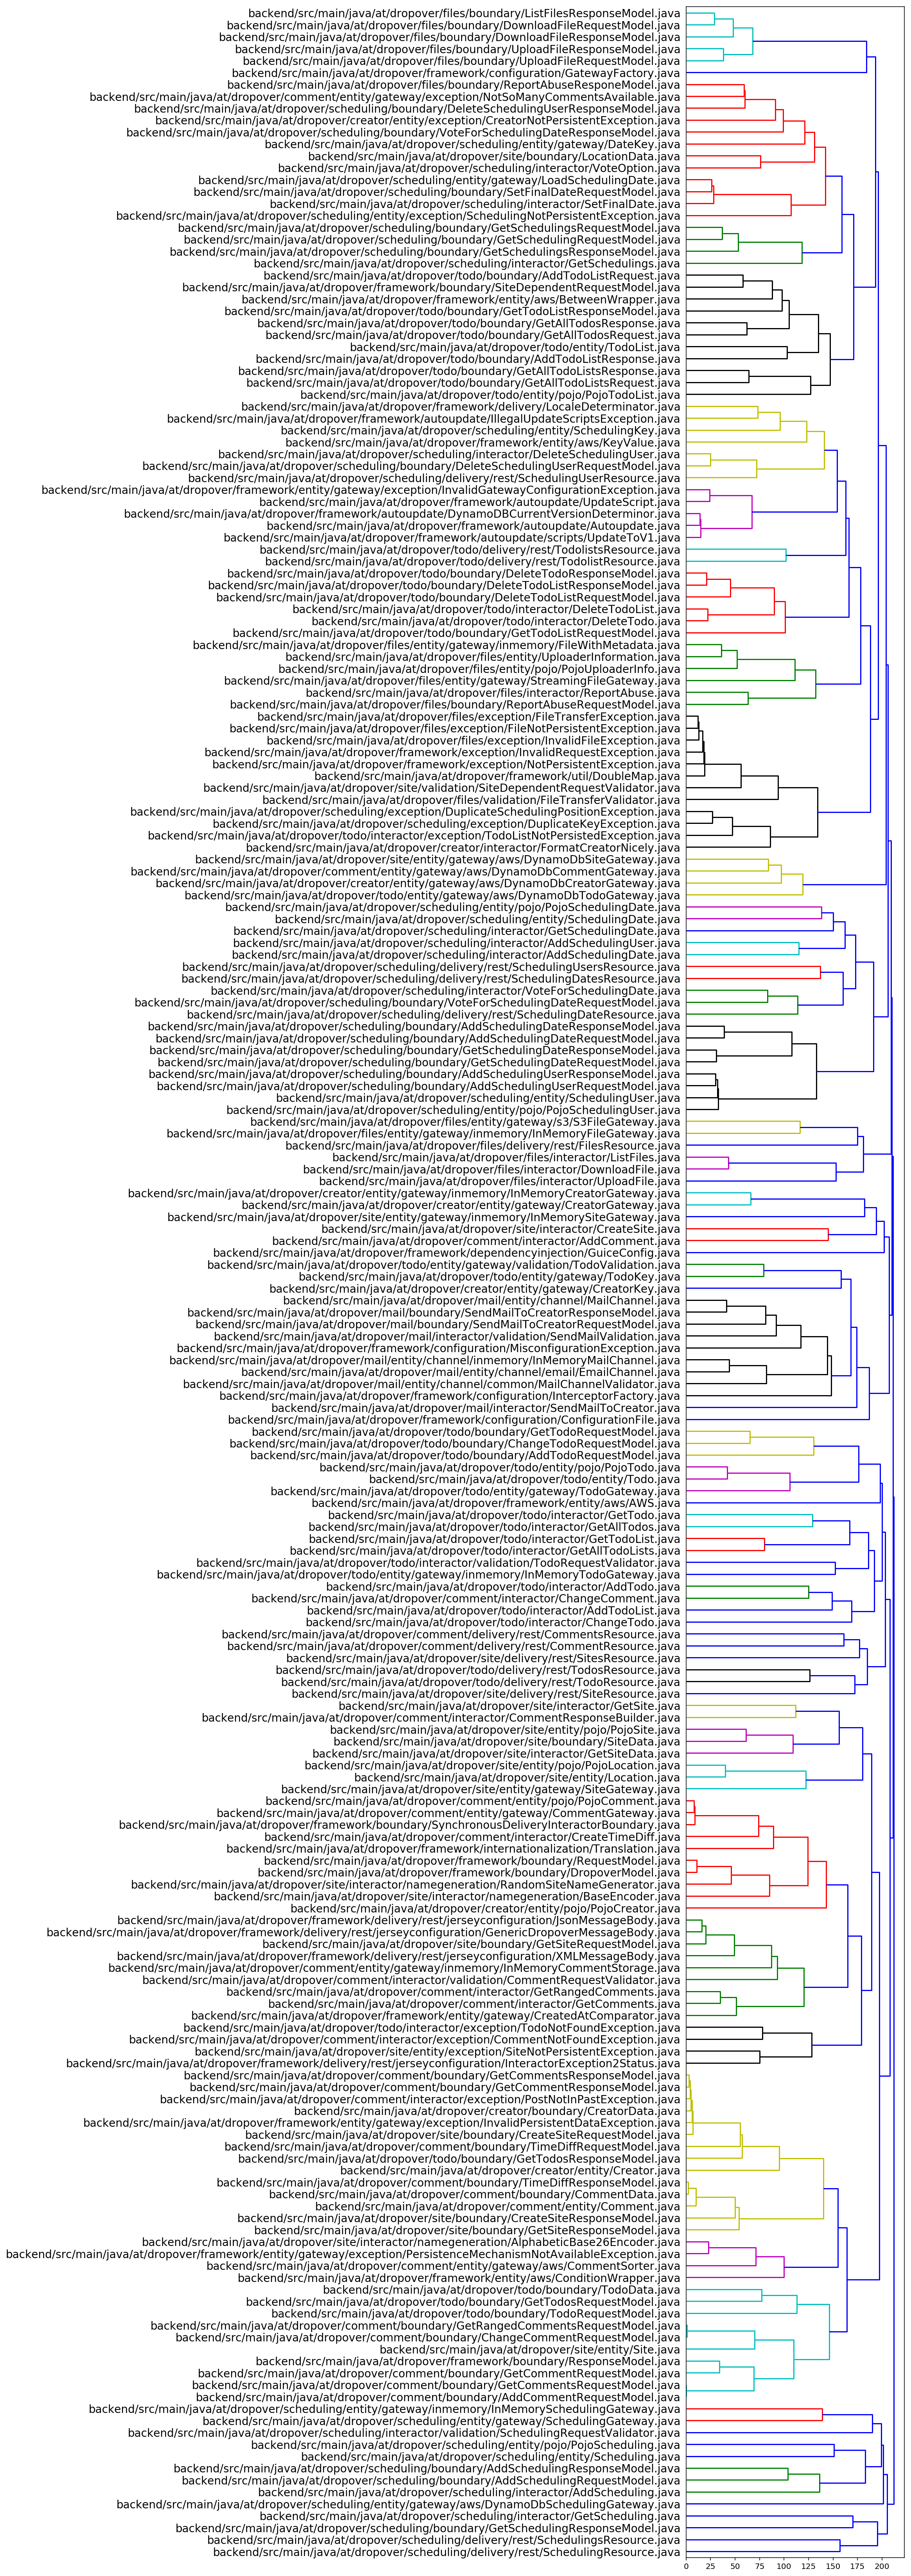

In [13]:
from ausi.scipy import plot_dendrogram
plot_dendrogram(model, labels=commit_matrix.index)

## End